In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.decomposition import PCA

# 5. PCA

In [63]:
num_imgs = len(os.listdir("preprocessed"))
images = np.empty((num_imgs, 64, 64), dtype=np.uint8)
for i, image in enumerate(sorted(os.listdir("preprocessed"))):
    im = Image.open("preprocessed/" + image)
    images[i,:,:] = np.array(im)

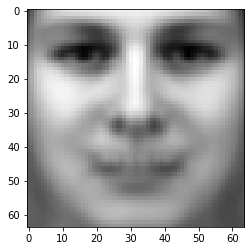

In [64]:
mean_image = images.mean(axis=0)
plt.imshow(mean_image, cmap="gray")
plt.show()

In [65]:
centered = images - mean_image
centered = centered.reshape(centered.shape[0], 64*64)

In [66]:
pca = PCA()
pca.fit(centered)

PCA()

In [67]:
transformed = pca.transform(centered)

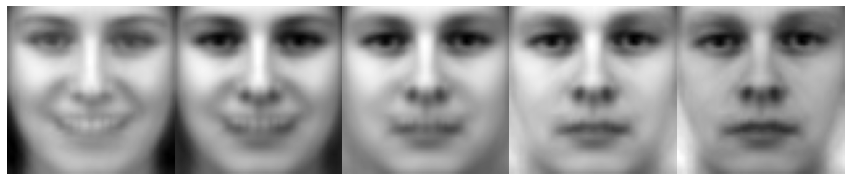

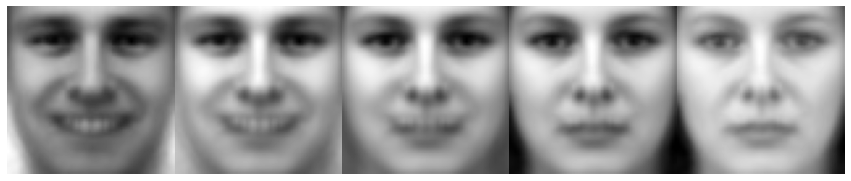

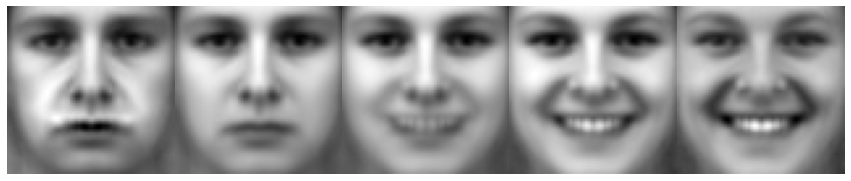

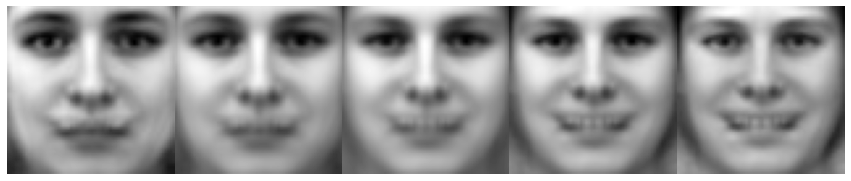

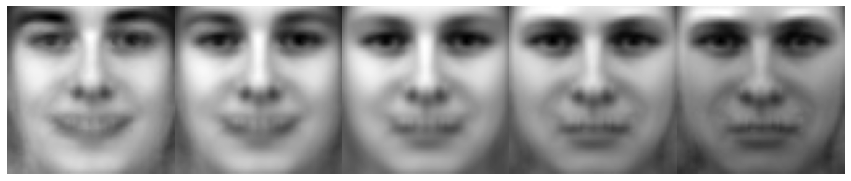

In [69]:
spectrum = 5
pcs = 5

for p in range(pcs):
    max = transformed[:,p].max()
    min = transformed[:,p].min()
    imgs = []
    for i in range(spectrum):
        value = min * (spectrum-1-i) / (spectrum - 1) + max * i / (spectrum - 1)
        vec = np.zeros((396))
        vec[p] = value
        img = pca.inverse_transform(vec).reshape(64,64) + mean_image
        imgs.append(img)
    f, axarr = plt.subplots(1,spectrum, figsize=(15,7))
    plt.subplots_adjust(wspace=0,
                    hspace=0)
    for i in range(spectrum):
        axarr[i].axis('off')
        axarr[i].imshow(imgs[i], cmap="gray")
    plt.show()

In [70]:
exp_var_pca = pca.explained_variance_ratio_
exp_var_pca[:5]

array([0.26343226, 0.14250964, 0.0713695 , 0.05346344, 0.04269085])

# Feature selection

In [82]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

In [80]:
ratings_df = pd.read_csv("ratings.csv", index_col=0)
ratings_df = ratings_df.sort_values("Image_ID")
ratings_df

aggregate = np.array(ratings_df.iloc[:,[1,2,3]].mean(axis=1))

In [ ]:
lin_reg = LinearRegression()
sfs = SequentialFeatureSelector(lin_reg)
sfs.fit(transformed, aggregate)